In [1]:
from typing import List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from visualization import papermode

papermode(plt, size=18)


In [17]:
# terrains = [
#     "asphalt",
#     "flooring",
#     "ice",
#     "sandy loam",
#     "snow",
# ]
# terrain_abbrs = u.import_terrain_abbrs_yaml(terrains)
# terrain_abbrs = {terr:[abbr for abbr in terr_abbrs if u.get_ugv(abbr) == "husky"] for terr, terr_abbrs in terrain_abbrs.items()}
# abbrs = [item for sublist in terrain_abbrs.values() for item in sublist]

# abbrs = (*u.abbrange("H", 1, 37), *u.abbrange("H", 39, 74))
abbrs = (*u.abbrange("H", 1, 15), *u.abbrange("H", 24, 28), "H31", *u.abbrange("H", 35, 37), *u.abbrange("H", 39, 74))
# abbrs = tuple(a for a in abbrs if a != "H50")

In [8]:
colors = u.COLORS
cols = {a: colors[u.get_terrain(a)] for a in abbrs}
terrains = sorted(set(u.get_terrain(a) for a in abbrs))
terr_cols = {terr: colors[terr] for terr in terrains}

# Simple labels
splabs = u.COLORS

def add_terrain_legend(mpl_elem: Union[mpl.axes.Axes, mpl.figure.Figure], highlighted: Optional[List[str]] = None):
    legend_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in terr_cols.items()]
    if highlighted is not None:
        legend_handles.extend([mpatches.Patch(color="xkcd:bright red", label=lab) for lab in highlighted])
    # mpl_elem.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0), loc="lower left")
    mpl_elem.legend(
        handles=legend_handles, ncol=len(colors), bbox_to_anchor=(0.5, -0.03), loc="upper center", title="Terrain"
    )


In [4]:
figdir = u.get_figdir("summary", subdir=f"multi-model-husky")

# Distribution

In [18]:
abbrs_dict = [{"abbr":a, "terrain":u.get_terrain(a)} for a in abbrs]
mu_df = pd.DataFrame(abbrs_dict)
model_values = u.model_subset_from_json(abbrs, pentzer2022.__MODEL_NAME__)
# mu_df["mu"] = mu_df.abbr.apply(lambda x: model_values[x]["coefficients"]["m_sym"]["last"])
m2009_dfs = {abbr: morales2009.open_model_df(abbr) for abbr in abbrs}
p2014_dfs = {abbr: pentzer2014pow.open_model_df(abbr) for abbr in abbrs}
p2022_dfs = {abbr: pentzer2022.open_model_df(abbr) for abbr in abbrs}
mu_df["mu_m2009"] = mu_df.abbr.apply(lambda x: m2009_dfs[x].m_sym.dropna().iloc[-int(len(m2009_dfs[x].dropna().index)/6):].to_numpy())
mu_df["mu_p2014"] = mu_df.abbr.apply(lambda x: p2014_dfs[x].m_sym.dropna().iloc[-int(len(p2014_dfs[x].dropna().index)/6):].to_numpy())
mu_df["mu_p2022"] = mu_df.abbr.apply(lambda x: p2022_dfs[x].m_sym.dropna().iloc[-int(len(p2022_dfs[x].dropna().index)/6):].to_numpy())

In [19]:
terrains = [
    "asphalt",
    "flooring",
    "ice",
    "sandy loam",
    "snow",
]
y_data = {
    "m2009": [np.concatenate(mu_df[mu_df.terrain == terr].mu_m2009.values) for terr in terrains],
    "p2014": [np.concatenate(mu_df[mu_df.terrain == terr].mu_p2014.values) for terr in terrains],
    "p2022": [np.concatenate(mu_df[mu_df.terrain == terr].mu_p2022.values) for terr in terrains],
}
models = tuple(y_data.keys())


def mod_abbr_to_name(mod_abbr: str) -> str:
    models_names = {
        "m2009": "Morales 2009",
        "p2014": "Pentzer 2014",
        "p2022": "Pentzer 2022",
    }
    return models_names[mod_abbr]


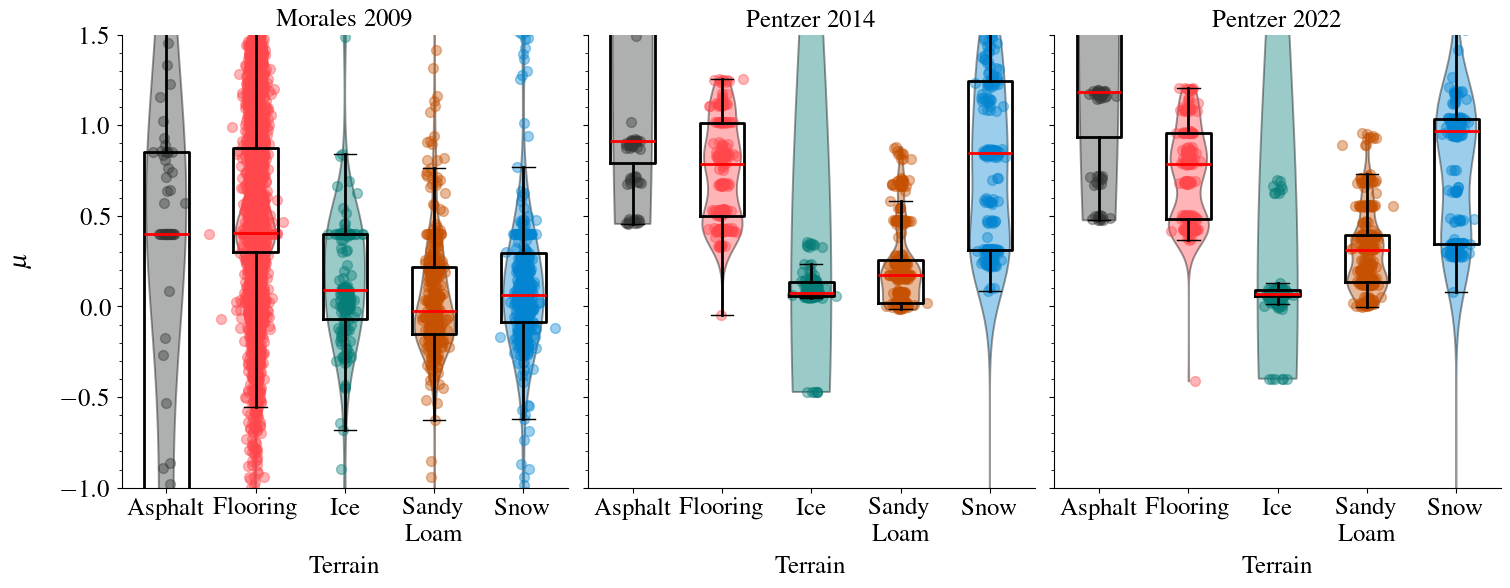

In [20]:
fig, subfigs = plt.subplots(sharey=True, ncols=3, figsize=(15,6))

for mod, ax in zip(models, subfigs.reshape(-1)):
    jitter = 0.04
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data[mod])]
    x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

    x_pos = [*range(len(y_data[mod]))]

    medianprops = dict(
        linewidth=2,
        color="r",
    )
    boxprops = dict(linewidth=2, color="k")

    violins = ax.violinplot(
        y_data[mod],
        positions=x_pos,
        widths=0.45,
        bw_method="silverman",
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )

    for pc, terr in zip(violins["bodies"], terrains):
        pc.set_facecolor(colors[terr])
        pc.set_edgecolor("k")
        pc.set_linewidth(1.4)
        pc.set_alpha(0.4)

    ax.boxplot(
        y_data[mod],
        positions=x_pos,
        showfliers=False,
        showcaps=True,  # Do not show the caps
        medianprops=medianprops,
        whiskerprops=boxprops,
        boxprops=boxprops,
    )

    for x, y, terr in zip(x_jittered, y_data[mod], terrains):
        ax.scatter(x, y, s=50, color=colors[terr], alpha=0.4)

    xlabels = [terr.title() for terr in terrains]
    xlabels[3] = "\n".join(xlabels[3].split(" "))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xlabels)

    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")

    ax.set_title(mod_abbr_to_name(mod).title())

    ax.set_xlabel("Terrain")
    ax.xaxis.set_label_coords(0.5, -0.15)


subfigs[0].set_ylim(bottom=-1, top=1.5)
subfigs[0].set_ylabel("$\mu$")
subfigs[0].yaxis.set_label_coords(-0.2, 0.5)
subfigs[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"mbplot.{ext}", bbox_inches="tight")


In [12]:
" ".join(abbrs)

'H01 H02 H03 H04 H05 H06 H07 H08 H09 H10 H11 H12 H13 H14 H24 H25 H26 H27 H31 H35 H36 H39 H40 H41 H42 H43 H44 H45 H46 H47 H48 H49 H51 H52 H53 H54 H55 H56 H57 H58 H59 H60 H61 H62 H63 H64 H65 H66 H67 H68 H69 H70 H71 H72 H73'

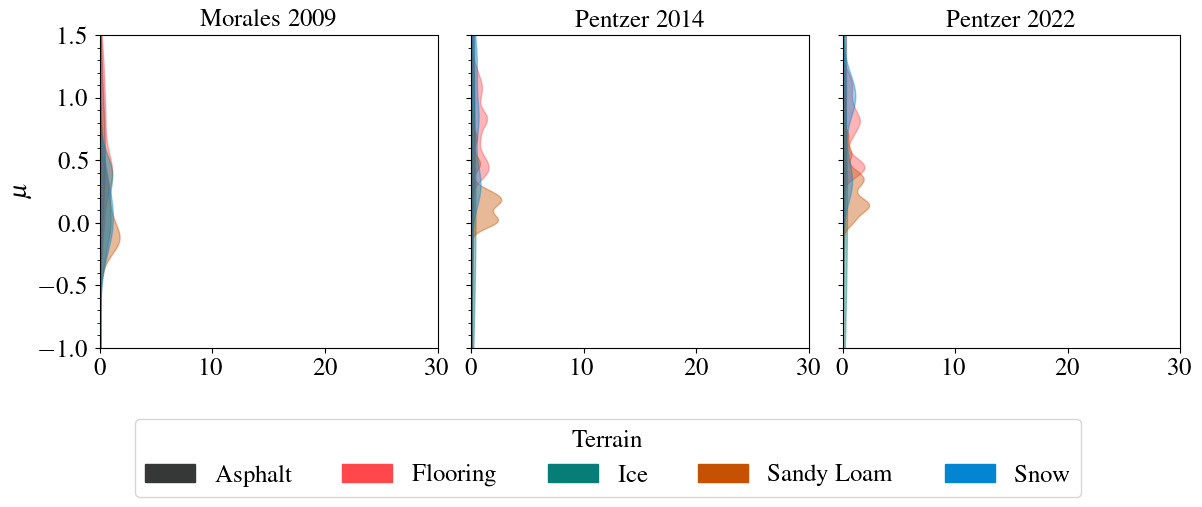

In [13]:
fig, subfigs = plt.subplots(figsize=(12,4), ncols=3, sharey=True)

subfigs[0].set_ylim(bottom=-1, top=1.5)
subfigs[0].set_ylabel("$\mu$")
subfigs[0].yaxis.set_label_coords(-0.2, 0.5)
subfigs[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

for mod, ax in zip(models, subfigs.reshape(-1)):
    ax.set_title(mod_abbr_to_name(mod).title())
    ax.set_xlim(left=0, right=30)
    ys = np.linspace(*subfigs[0].get_ylim(), num=300)

    for terr, terr_mu in zip(terrains, y_data[mod]):
        terr_col = colors[terr]

        density = st.gaussian_kde(terr_mu)
        density.covariance_factor = lambda: .25
        density._compute_covariance()

        ax.fill_betweenx(ys, density(ys), color=terr_col, alpha=0.4)

add_terrain_legend(fig)
fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"mdist.{ext}", bbox_inches="tight")

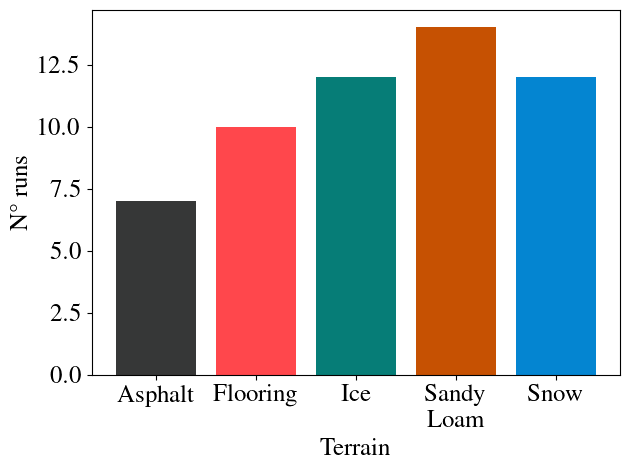

In [14]:
mu_df
fig, ax = plt.subplots()

bar_terrains = terrains.copy()
bar_labels = [terr.title() for terr in bar_terrains]
bar_labels[3] = "\n".join(bar_labels[3].split(" "))
bar_colors = [terr_cols[terr] for terr in bar_terrains]
counts = [len(mu_df[mu_df.terrain == terr]) for terr in bar_terrains]

ax.bar(bar_labels, counts, color=bar_colors)
ax.set_ylabel("N° runs")
ax.set_xlabel("Terrain")
fig.tight_layout()


In [15]:
mu_df

abbr     terrain                                           mu_m2009  \
0   H01  sandy loam  [1.1601649400198324, 1.0713382784601837, 0.908...   
1   H02  sandy loam           [0.4560651018442823, 0.2759158824689184]   
2   H03  sandy loam  [-0.1299039260979251, -0.1337719164996502, -0....   
3   H04  sandy loam  [0.0787989610328612, 0.0708745065884893, 0.091...   
4   H05  sandy loam  [0.0261167265485836, 0.0033978745691084, -0.05...   
5   H06  sandy loam  [1.313631236047125, 1.555505801402152, 1.57095...   
6   H07  sandy loam  [0.2555535730183499, -0.2839161122853169, -0.2...   
7   H08  sandy loam  [-0.1098049541749942, -0.2658650181893296, -0....   
8   H09  sandy loam  [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...   
9   H10  sandy loam  [0.0852328650840777, 0.053178649719627, 0.0420...   
10  H11  sandy loam  [-0.030402422342807, -0.0218791814125203, 0.10...   
11  H12  sandy loam  [0.231573193904446, 0.2370804664697018, 0.2356...   
12  H13  sandy loam  [-0.262705046265609, -0.1480859350086246, -0.3...   
13  H14  sandy loam  [-0.1459739636631451, -0.1312497522319896, -0....   
14  H24     asphalt  [0.0867638109909667, -0.1731958159971527, -0.2...   
15  H25     asphalt  [-0.8655440519313247, -0.8912166251557383, -0....   
16  H26     asphalt  [2.6739892240355108, 2.6545545164625333, 2.701...   
17  H27     asphalt  [0.6350064075145201, 0.7149033057282554, 0.765...   
18  H31     asphalt                               [0.6433013535044569]   
19  H35     asphalt                                [2.364818728410942]   
20  H36     asphalt  [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...   
21  H39    flooring  [-0.1433781942534766, -0.1045172937382617, -0....   
22  H40    flooring  [0.0844588917924164, 0.1371179344695562, 0.165...   
23  H41    flooring  [0.9852748436668568, 1.0244167765857584, 1.027...   
24  H42    flooring  [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...   
25  H43    flooring  [0.9774960720749702, 0.9416071617541776, 0.935...   
26  H44    flooring  [0.3894111078610029, 0.719809851662043, 0.9644...   
27  H45    flooring  [0.4, 5.224993125510805e-60, 1.472726181417005...   
28  H46    flooring  [-0.1466331412221947, -0.4838132911409308, -0....   
29  H47    flooring  [1.2379638972340063, 1.2863443297271404, 1.372...   
30  H48    flooring  [0.4720012900648269, 0.483086882492969, 0.4833...   
31  H49         ice  [0.0841611384713212, 0.1544107535169188, -0.01...   
32  H51         ice  [0.0194979687491095, -0.0314466698025956, -0.0...   
33  H52         ice  [0.4, 0.4, 0.0215091917384972, -0.446871608385...   
34  H53         ice  [0.0939494420129667, 0.1062618779024095, 0.148...   
35  H54         ice  [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...   
36  H55         ice  [0.0968278369532362, 0.1170352442382889, 0.105...   
37  H56         ice  [-0.6450053649712078, -0.3115741485013399, -0....   
38  H57         ice  [0.3908976983182559, 0.3970663001336116, 0.405...   
39  H58         ice  [-0.1634579557225853, 0.0671680667402876, 0.06...   
40  H59         ice  [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...   
41  H60         ice  [0.0194580637275913, 0.0216538826126972, 0.029...   
42  H61         ice  [-1.5775187796150296, -1.605433299256268, -1.6...   
43  H62        snow  [-0.1837100638976479, -0.1413992110183848, -0....   
44  H63        snow  [1.664064182019272, 1.9172012133982612, 1.7995...   
45  H64        snow  [0.0221432528368494, 0.0162902391096171, 0.010...   
46  H65        snow  [-0.6225952581621201, -0.8944630918754743, -1....   
47  H66        snow  [-2.3598737402865244, -2.436015349572716, -2.3...   
48  H67        snow  [-0.0760437171711219, -0.1566258217644107, -0....   
49  H68        snow  [0.4, 0.2931267265322, 0.3309329216826054, 0.3...   
50  H69        snow  [0.213320130662466, 0.2151993529095663, 0.1953...   
51  H70        snow  [-0.3762738952843794, -0.3774016448263112, -0....   
52  H71        snow  [0.4, 0.4655455486375658, 0.5796694793218596, ...   
53  H72

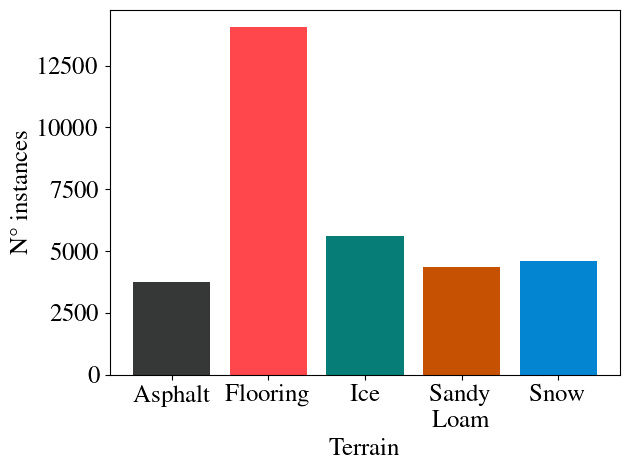

In [16]:
fig, ax = plt.subplots()

bar_terrains = terrains.copy()
bar_labels = [terr.title() for terr in bar_terrains]
bar_labels[3] = "\n".join(bar_labels[3].split(" "))
bar_colors = [terr_cols[terr] for terr in bar_terrains]
bar_abbrs = [mu_df[mu_df.terrain == terr].abbr for terr in bar_terrains]
bar_counts = [[len(p2022_dfs[ab].index) for ab in terr_abbr] for terr_abbr in bar_abbrs]
counts = [sum(terr_count) for terr_count in bar_counts]

ax.bar(bar_labels, counts, color=bar_colors)
ax.set_ylabel("N° instances")
ax.set_xlabel("Terrain")
fig.tight_layout()